In [ ]:
import tensorflow
import numpy


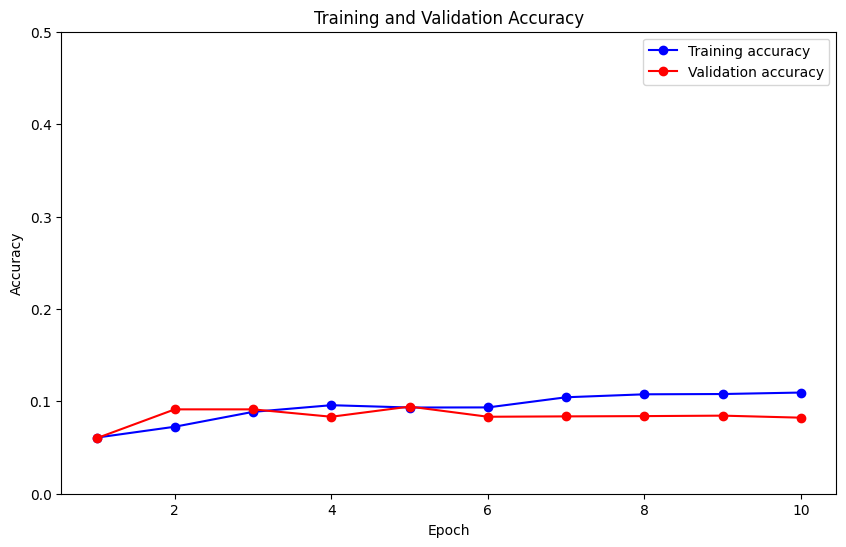

In [ ]:
import matplotlib.pyplot as plt

# Manually specified accuracy and validation accuracy data
acc = [0.0607, 0.0725, 0.0886, 0.0958, 0.0933, 0.0934, 0.1044, 0.1076, 0.1079, 0.1095]
val_acc = [0.0600, 0.0913, 0.0913, 0.0833, 0.0943, 0.0833, 0.0837, 0.0840, 0.0845, 0.0823]
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,0.5)
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from PIL import Image
import numpy as np
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, TimeDistributed, concatenate, Reshape, Embedding
from tensorflow.keras.models import Model

In [ ]:
import pandas as pd

# Load the CSV file
data_path = '/content/gdrive/MyDrive/CX4803GroupProject/Ecolil_new.csv'
images_path = '/content/gdrive/MyDrive/CX4803GroupProject/data_4363/data/'
data = pd.read_csv(data_path) [1: 1000]

# Display the first few rows of the dataframe
print(data.head())


  UniProt ID                                           Sequence
1     P06612  MGKALVIVESPAKAKTINKYLGSDYVVKSSVGHIRDLPTSGSAAKK...
2     P75830  MKKRKTVKKRYVIALVIVIAGLITLWRILNAPVPTYQTLIVRPGDL...
3     P03018  MDVSYLLDSLNDKQREAVAAPRSNLLVLAGAGSGKTRVLVHRIAWL...
4     P39390  MEFHENRAKAPFIGLVQLWQAVRRWRRQMQTRRVLQQMSDERLKDI...
5     P03030  MAAVNLRHIEIFHAVMTAGSLTEAAHLLHTSQPTVSRELARFEKVI...


In [ ]:
import numpy as np
import os
from PIL import Image
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Load the CSV file
data_path = '/content/gdrive/MyDrive/CX4803GroupProject/Ecolil_new.csv'
images_path = '/content/gdrive/MyDrive/CX4803GroupProject/data_4363/data/'
data = pd.read_csv(data_path)[1: 1000]

# Function to load and preprocess images
def load_and_preprocess_images(images_list):
    stacked_images = None
    for image_path in images_list:
        with Image.open(image_path) as img:
            img_array = np.array(img).astype(np.float32) / 255.0
        if stacked_images is None:
            stacked_images = img_array
        else:
            stacked_images = np.concatenate((stacked_images, img_array), axis=-1)
    return stacked_images

# Process each protein's images
processed_images = []
for index, row in data.iterrows():
    uniprot_id = row['UniProt ID']
    images_list = [
        os.path.join(images_path, f"{uniprot_id}_{orientation}.png")
        for orientation in ['front', 'back', 'top', 'left', 'right', 'bottom']
    ]

    if all(os.path.exists(img) for img in images_list):
        processed_image = load_and_preprocess_images(images_list)
        processed_images.append(processed_image)
    else:
        print(f"Missing images for protein {uniprot_id}")

# Convert list of images to a numpy array
processed_images = np.stack(processed_images)

# Custom mapping for amino acids
amino_acids_mapping = {amino_acid: i + 1 for i, amino_acid in enumerate('ACDEFGHIKLMNPQRSTVWY')}

# Sequence Preprocessing
# Tokenize the sequences based on custom mapping
sequences = [[amino_acids_mapping[char] for char in sequence] for sequence in data['Sequence']]

# Padding sequences
max_sequence_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Splitting data
train_images, test_images, train_sequences, test_sequences = train_test_split(
    processed_images,
    padded_sequences,
    test_size=0.2,
    random_state=42
)

train_labels = train_sequences

# Print shapes
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Sequences Shape: {train_sequences.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Sequences Shape: {test_sequences.shape}")


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# 计算类别权重
labels_for_class_weights = train_labels.flatten()  # 确保标签是1D数组
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_for_class_weights),
    y=labels_for_class_weights
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Concatenate, Embedding, TimeDistributed, RepeatVector

# Define model inputs
image_input = Input(shape=(480, 640, 24))  # Image input
sequence_input = Input(shape=(None,))  # Variable sequence length

#embedding layer
embedding_layer = Embedding(input_dim=21, output_dim=128)(sequence_input)

# CNN Layers
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
cnn_output = Dense(128, activation='relu')(x)

# Assuming the time steps for the LSTM outputs are known or calculated
time_steps = 1538  # This should be set to match your specific sequence length or LSTM output
cnn_output_repeated = RepeatVector(time_steps)(cnn_output)

# LSTM Layers
y = LSTM(128, return_sequences=True)(embedding_layer)
y = LSTM(128, return_sequences=True)(y)
lstm_output = Dense(128, activation='relu')(y)

# Concatenate CNN and LSTM outputs
combined = Concatenate()([cnn_output_repeated, lstm_output])
z = TimeDistributed(Dense(256, activation='relu'))(combined)
output = TimeDistributed(Dense(25, activation='softmax'))(z)  # Adjust for the actual number of output classes

# Create and compile the model
model = Model(inputs=[image_input, sequence_input], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 480, 640, 24)]       0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 478, 638, 32)         6944      ['input_7[0][0]']             
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 239, 319, 32)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 237, 317, 64)         18496     ['max_pooling2d_2[0][0]'] 

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Reduced batch size
batch_size = 8  # Adjusted from 32 to 16

dummy_train_sequences = np.random.randint(0, 21, size=(160, max_sequence_length))
dummy_test_sequences = np.random.randint(0, 21, size=(40, max_sequence_length))

# Use these dummy data as the validation data in model fitting
history = model.fit(
    [train_images, dummy_train_sequences],
    train_labels,
    validation_data=([test_images, dummy_test_sequences],test_sequences),
    epochs=10,
    batch_size=batch_size,
    verbose=1
)




Epoch 1/10
20/20 [==============================] - 130s 6s/step - loss: 3.0383 - accuracy: 0.6643 - val_loss: 1.0384 - val_accuracy: 0.8206
Epoch 2/10
20/20 [==============================] - 123s 6s/step - loss: 1.1561 - accuracy: 0.7802 - val_loss: 0.9621 - val_accuracy: 0.8206
Epoch 3/10
20/20 [==============================] - 150s 8s/step - loss: 1.1087 - accuracy: 0.7802 - val_loss: 0.9699 - val_accuracy: 0.8206
Epoch 4/10
20/20 [==============================] - 123s 6s/step - loss: 1.2084 - accuracy: 0.7769 - val_loss: 1.0051 - val_accuracy: 0.8206
Epoch 5/10
20/20 [==============================] - 123s 6s/step - loss: 1.1205 - accuracy: 0.7802 - val_loss: 1.0041 - val_accuracy: 0.8206
Epoch 6/10
20/20 [==============================] - 134s 7s/step - loss: 1.1090 - accuracy: 0.7802 - val_loss: 0.9824 - val_accuracy: 0.8206
Epoch 7/10
20/20 [==============================] - 124s 6s/step - loss: 1.0930 - accuracy: 0.7802 - val_loss: 0.9686 - val_accuracy: 0.8206
Epoch 8/10
20

In [ ]:
# Assuming 'model' is your trained model, you might use it like this:
# predicted_sequences = model.predict(test_images)
# For demonstration, let's create a dummy 'predicted_sequences' similar to 'test_sequences'
predicted_sequences = dummy_test_sequences  # This should be replaced with actual model predictions

actual_sequences_letters=test_sequences

reverse_amino_acids_mapping = {i: amino_acid for amino_acid, i in amino_acids_mapping.items()}

# Convert integer sequences back to letters
predicted_sequences_letters = [
    ''.join(reverse_amino_acids_mapping.get(char, '-') for char in sequence if char != 0)
    for sequence in predicted_sequences
]

actual_sequences_letters = [
    ''.join(reverse_amino_acids_mapping.get(char, '-') for char in sequence if char != 0)
    for sequence in test_sequences
]

# Save predicted sequences to a file
predicted_file_path = '/content/gdrive/MyDrive/CX4803GroupProject/ozi_predicted_sequences_2.txt'
with open(predicted_file_path, 'w') as predicted_file:
    for sequence in predicted_sequences_letters:
        predicted_file.write(sequence + '\n')

# Save actual sequences to a file
actual_file_path = '/content/gdrive/MyDrive/CX4803GroupProject/ozi_actual_sequences_2.txt'
with open(actual_file_path, 'w') as actual_file:
    for sequence in actual_sequences_letters:
        actual_file.write(sequence + '\n')

print("Predicted sequences saved to:", predicted_file_path)
print("Actual sequences saved to:", actual_file_path)


Predicted sequences saved to: /content/gdrive/MyDrive/CX4803GroupProject/ozi_predicted_sequences_2.txt
Actual sequences saved to: /content/gdrive/MyDrive/CX4803GroupProject/ozi_actual_sequences_2.txt


In [ ]:
predicted_sequences_indices

array([[ 4, 10, 20, ..., 11, 11, 11],
       [ 4, 21, 14, ..., 11, 11, 11],
       [ 4,  8,  5, ..., 11, 11, 11],
       ...,
       [ 4, 18,  2, ..., 11, 11, 11],
       [ 4, 14, 14, ..., 11, 11, 11],
       [ 4, 11, 14, ..., 11, 11, 11]])

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))


{0: 194164, 2: 2684, 3: 5571, 4: 1461, 5: 2872, 6: 1169, 7: 639, 8: 3899, 9: 2352, 10: 2027, 11: 3094, 12: 2286, 13: 2927, 14: 2765, 15: 729, 16: 3020, 17: 1519, 18: 1939, 19: 3713, 20: 2350, 21: 4900}


In [ ]:
# 假设 tokenizer 是你之前创建的 Tokenizer 实例
index_to_char = tokenizer.index_word  # 获取从索引到字符的映射

def indices_to_sequence(indices_array):
    sequences = []
    for sequence_indices in indices_array:
        # 将每个索引转换为对应的字符，并合并为字符串
        sequence = ''.join(index_to_char.get(idx, '') for idx in sequence_indices)
        sequences.append(sequence)
    return sequences

# 将预测的索引数组转换为字符序列
predicted_sequences = indices_to_sequence(predicted_sequences_indices)

# 打印一些预测的序列来检查结果
for i, sequence in enumerate(predicted_sequences[:10]):  # 打印前10个预测序列
    print(f"Sequence {i+1}: {sequence}")


Sequence 1: mnkdstqtwglkrditpcfgarlvqeghrlhfladragftgsfsevqtlqldeafphfvahlelmllscelnpryahcvtlyrngltgeadtlgshgyvyiailnrhgfnrhlrviiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii

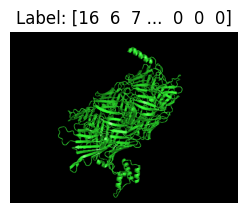

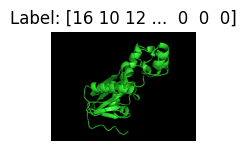

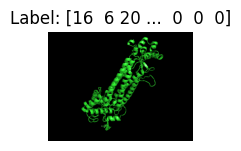

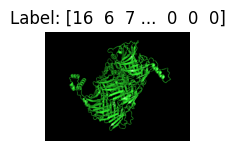

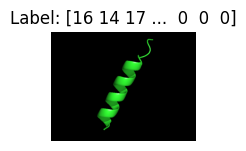

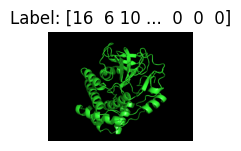

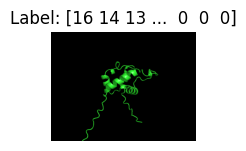

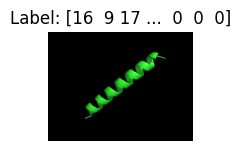

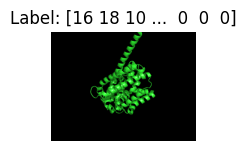

In [ ]:
import matplotlib.pyplot as plt

# 显示几个图像和它们的标签
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)



    # 只显示前3个通道
    plt.imshow(train_images[i][:, :, :3])  # 显示RGB的前三个通道
    plt.title('Label: ' + str(train_labels[i]))
    plt.axis("off")
    plt.show()



In [ ]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 480, 640, 24)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 478, 638, 32)         6944      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 239, 319, 32)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 237, 317, 64)         18496     ['max_pooling2d[0][0]']   

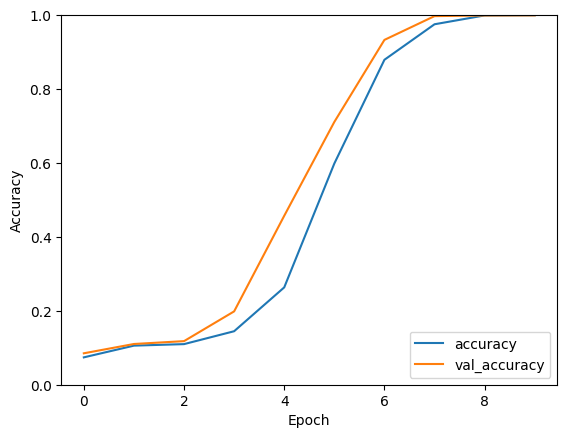

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')


In [ ]:
from tensorflow.keras.optimizers import Adam

# 尝试一个较低的学习率
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Specify the directory where you want to save the model
model_save_path = '/content/gdrive/MyDrive/CX4803GroupProject/new_model'

# Save the model
model.save(model_save_path)

In [ ]:
# Load the model
loaded_model = tf.keras.models.load_model(model_save_path)

# Predict using the loaded model
# 'test_images' should be your test set images
# 'test_dummy_sequences' is a dummy sequence of appropriate shape (zeros, in this case)
predictions = loaded_model.predict([test_images, test_dummy_sequences])

# Convert predictions from probabilities to sequence indices
predicted_sequences_indices = np.argmax(predictions, axis=-1)

# Translate indices to amino acids using the tokenizer
predicted_sequences = [''.join([tokenizer.index_word.get(idx, '') for idx in pred_seq]) for pred_seq in predicted_sequences_indices]

# Here, we would typically save the predicted sequences to a file or use them as needed.

In [ ]:
predictions = loaded_model.predict([test_images, test_dummy_sequences])